In [1]:
! pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=d70a4582c951a79c9d75f32df970a840fcbaae70212c33d13dc331c09146a303
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
from ta.trend import SMAIndicator, EMAIndicator, MACD
from ta.momentum import RSIIndicator
from ta.volume import OnBalanceVolumeIndicator
from pandas.tseries.offsets import BDay

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

from tqdm import tqdm

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Récupérer les données boursières
def get_stock_data(symbol, start, end):
    data = yf.download(symbol, start=start, end=end)
    data.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
    return data

# Calcul des indicateurs techniques
def calculate_indicators(df):
    df['MAV5Day'] = SMAIndicator(df['Volume'], window=5).sma_indicator()
    df['RSI3Day'] = RSIIndicator(df['Close'], window=3).rsi()
    df['RSI9Day'] = RSIIndicator(df['Close'], window=9).rsi()
    df['RSI14Day'] = RSIIndicator(df['Close'], window=14).rsi()
    df['RSI30Day'] = RSIIndicator(df['Close'], window=30).rsi()
    df['MA10Day'] = SMAIndicator(df['Close'], window=10).sma_indicator()
    df['MA30Day'] = SMAIndicator(df['Close'], window=30).sma_indicator()
    df['MA50Day'] = SMAIndicator(df['Close'], window=50).sma_indicator()
    df['EMA10Day'] = EMAIndicator(df['Close'], window=10).ema_indicator()

    # Variation de prix
    df['PriceChange'] = df['Close'].diff()
    df['CloseOpenDiff'] = df['Close'] - df['Open']
    df['HighLowDiff'] = df['High'] - df['Low']

    # MACD
    macd = MACD(df['Close'])
    df['MACD'] = macd.macd()
    df['Signal'] = macd.macd_signal()

    # OBV
    obv = OnBalanceVolumeIndicator(df['Close'], df['Volume'])
    df['OBV'] = obv.on_balance_volume()

    return df

# Créer le DataFrame complet
def create_stock_dataframe(symbol, start, end, sp500='^GSPC', cac40='^FCHI'):
    data = get_stock_data(symbol, start, end)
    data = calculate_indicators(data)

    sp500_data = get_stock_data(sp500, start, end)[['Close']]
    cac40_data = get_stock_data(cac40, start, end)[['Close']]

    sp500_data.columns = ['SP_Close']
    cac40_data.columns = ['CAC_Close']

    df = data.merge(sp500_data, left_index=True, right_index=True, how='left')
    df = df.merge(cac40_data, left_index=True, right_index=True, how='left')

    return df

In [5]:
# Récupérer les données et combiner
start_date = '2010-01-01'
end_date = '2024-10-31'
df_stock = create_stock_dataframe('ADBE', start_date, end_date)

# Ajouter Quarter et manipulations temporelles
df_stock['Date'] = pd.to_datetime(df_stock.index)

df_stock['Quarter'] = df_stock['Date'].dt.to_period('M').astype(str)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [6]:
macro_sentiment = pd.read_csv('/content/drive/MyDrive/Deep Learning ENSAI/macro_sentiment_info.csv')
macro_sentiment['DATE'] = pd.to_datetime(macro_sentiment['DATE'])
macro_sentiment['Quarter'] = macro_sentiment['DATE'].dt.to_period('M').astype(str)

combined_df = pd.merge(df_stock, macro_sentiment, on='Quarter', how='left')
combined_df.drop(columns=['Quarter', 'DATE'], inplace=True)
combined_df.sort_values(by='Date', inplace=True)

In [7]:
vol_data = pd.read_csv('/content/drive/MyDrive/Deep Learning ENSAI/volatilite_estimee.csv')
vol_data['Date'] = pd.to_datetime(vol_data['Date'])
combined_df = pd.merge(combined_df, vol_data, on='Date', how='left')

# Imputation des valeurs manquantes
combined_df[['SP_Close', 'CAC_Close']] = combined_df[['SP_Close', 'CAC_Close']].ffill()

missing_sp500 = combined_df['SP_Close'].isna().sum()
missing_cac40 = combined_df['CAC_Close'].isna().sum()

print(f"Nombre de valeurs manquantes dans SP_Close après imputation : {missing_sp500}")
print(f"Nombre de valeurs manquantes dans CAC_Close après imputation : {missing_cac40}")

Nombre de valeurs manquantes dans SP_Close après imputation : 0
Nombre de valeurs manquantes dans CAC_Close après imputation : 0


In [8]:
combined_df['sovereign_debt_crisis'] = ((combined_df['Date'] >= '2010-01-01') &
                                        (combined_df['Date'] <= '2012-12-31')).astype(int)

combined_df['oil_shock'] = ((combined_df['Date'] >= '2014-01-01') &
                            (combined_df['Date'] <= '2016-12-31')).astype(int)

combined_df['trade_war'] = ((combined_df['Date'] >= '2018-01-01') &
                            (combined_df['Date'] <= '2019-12-31')).astype(int)

combined_df['covid_pandemic'] = ((combined_df['Date'] >= '2020-01-01') &
                                 (combined_df['Date'] <= '2022-12-31')).astype(int)

combined_df['war_ukraine'] = (combined_df['Date'] >= '2022-02-24').astype(int)

In [9]:
# Rendement logarithmique
combined_df['Rend'] = np.log(combined_df['Close'] / combined_df['Close'].shift(1))

combined_df['Close'].describe()

,Close
count,3732.000000
mean,224.193682
std,193.866639
min,22.690001
25%,49.185000
50%,139.305000
75%,379.185005
max,688.369995


In [10]:
# Préparation des données
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        targets.append(data[i + seq_length, 0])
    return torch.tensor(sequences, dtype=torch.float32), torch.tensor(targets, dtype=torch.float32)

In [11]:
combined_df['Date'] = pd.to_datetime(combined_df['Date'])

# Trouver l'index correspondant au 1er janvier 2024
split_date = pd.Timestamp('2024-01-01')
split_index = combined_df[combined_df['Date'] >= split_date].index[0]

In [12]:
len(['Close', 'Volume', 'MAV5Day', 'RSI3Day', 'RSI9Day', 'RSI14Day', 'RSI30Day', 'MA10Day', 'MA30Day','MA50Day', 'EMA10Day', 'PriceChange', 'CloseOpenDiff', 'HighLowDiff',
       'MACD', 'Signal', 'OBV', 'SP_Close', 'CAC_Close', 'EMVMACROBUS','CPIAUCSL', 'EXPINF1YR', 'LNS12032195', 'UMCSENT',
            'Sigma', 'Sigma2', 'sovereign_debt_crisis', 'oil_shock', 'trade_war', 'covid_pandemic', 'war_ukraine'])

31

In [22]:
# Prétraitement des données
features = ['Close', 'Volume', 'MAV5Day', 'RSI3Day', 'RSI9Day', 'RSI14Day', 'RSI30Day', 'MA10Day', 'MA30Day','MA50Day', 'EMA10Day', 'PriceChange', 'CloseOpenDiff', 'HighLowDiff',
       'MACD', 'Signal', 'OBV', 'SP_Close', 'CAC_Close', 'EMVMACROBUS','CPIAUCSL', 'EXPINF1YR', 'LNS12032195', 'UMCSENT',
            'Sigma', 'Sigma2', 'sovereign_debt_crisis', 'oil_shock', 'trade_war', 'covid_pandemic', 'war_ukraine']


data = combined_df[['Date'] + features]
data = data.dropna()
data.set_index('Date', inplace=True)

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Paramètres
seq_length = 40

# Séparer les données en train et test
train_data = data_scaled[:split_index]
test_data = data_scaled[split_index - seq_length:]

X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

# Dataloader
batch_size = 32
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [23]:
# Création du modèle LSTM Bidirectionnel
class BiLSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout):
        super(BiLSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, dropout=dropout, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

input_dim = X_train.shape[2]
hidden_dim = 40
output_dim = 1
num_layers = 2
dropout = 0.2

model = BiLSTMModel(input_dim, hidden_dim, output_dim, num_layers, dropout)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [24]:
# Entraînement
epochs = 15
for epoch in tqdm(range(epochs), "Epoch"):
    model.train()
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y.unsqueeze(1))
        loss.backward()
        optimizer.step()

Epoch: 100%|██████████| 15/15 [00:29<00:00,  1.94s/it]


In [25]:
# Évaluation
model.eval()
y_pred = []
y_true = []
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X)
        y_pred.append(outputs.numpy())
        y_true.append(batch_y.numpy())

y_pred = np.concatenate(y_pred).flatten()
y_true = np.concatenate(y_true).flatten()

# Inverse scaling
y_test_inv = scaler.inverse_transform(np.concatenate((y_true.reshape(-1, 1), test_data[seq_length:, 1:]), axis=1))[:, 0]
y_pred_inv = scaler.inverse_transform(np.concatenate((y_pred.reshape(-1, 1), test_data[seq_length:, 1:]), axis=1))[:, 0]

# Évaluation des performances
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae = mean_absolute_error(y_test_inv, y_pred_inv)
mape = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}%")

RMSE: 18.66657893544269
MAE: 13.876566214467529
MAPE: 2.6888787861106116%


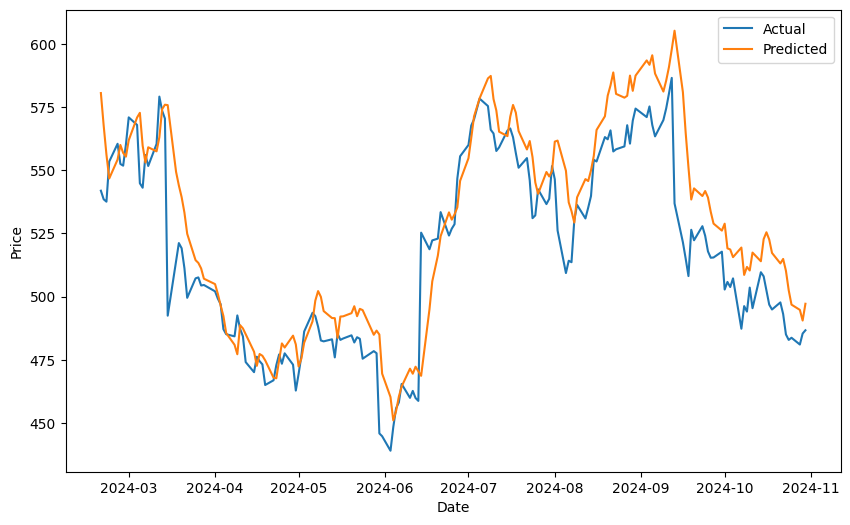

In [26]:
# Visualisation
plt.figure(figsize=(10, 6))
#plt.plot(data.index, data.Close, label='Série complète')
plt.plot(data.index[-len(y_test_inv):], y_test_inv, label='Actual')
plt.plot(data.index[-len(y_pred_inv):], y_pred_inv, label='Predicted')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [27]:
# Analyse de la contribution des variables
def variable_contribution(data, model, seq_length):
    base_loss = rmse
    contributions = []

    for i in tqdm(range(1, data.shape[1]), desc="Contribution"):
        permuted_losses = []

        for _ in range(30):
            temp_data = test_data.copy()
            np.random.shuffle(temp_data[:, i])
            X_temp, y_temp = create_sequences(temp_data, seq_length)

            model.eval()
            y_temp_pred = []
            with torch.no_grad():
                for X_batch, _ in DataLoader(TensorDataset(X_temp, y_temp), batch_size=batch_size, shuffle=False):
                    outputs = model(X_batch)
                    y_temp_pred.append(outputs.numpy())

            y_temp_pred = np.concatenate(y_temp_pred).flatten()

            y_temp_pred = scaler.inverse_transform(
                np.concatenate((y_temp_pred.reshape(-1, 1), test_data[seq_length:, 1:]), axis=1)
            )[:, 0]

            y_temp = scaler.inverse_transform(
                np.concatenate((y_temp.reshape(-1, 1), test_data[seq_length:, 1:]), axis=1)
            )[:, 0]

            temp_loss = np.sqrt(mean_squared_error(y_temp, y_temp_pred))
            permuted_losses.append(temp_loss)

        contributions.append(np.mean(permuted_losses) - base_loss)

    return contributions

In [28]:
contributions = variable_contribution(data_scaled, model, seq_length)

Contribution: 100%|██████████| 8/8 [00:12<00:00,  1.50s/it]


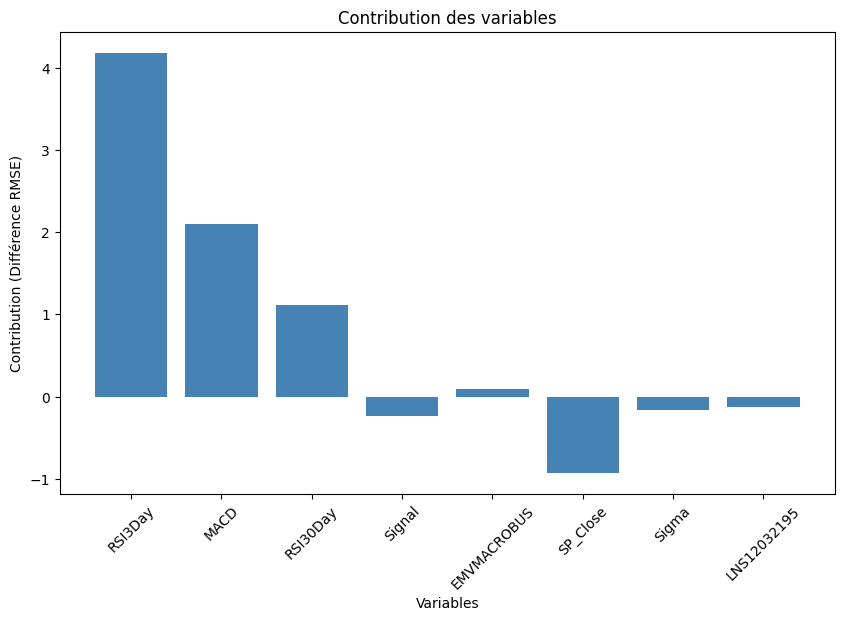

In [29]:
# Affichage des contributions
plt.figure(figsize=(10, 6))
plt.bar(features[1:], contributions, color='steelblue')
plt.xticks(rotation=45)
plt.title('Contribution des variables')
plt.xlabel('Variables')
plt.ylabel('Contribution (Différence RMSE)')
plt.show()

In [21]:
df = pd.DataFrame({
    'Feature': features[1:],  # Exclure le premier élément si nécessaire
    'Contribution': contributions
})

df.sort_values(by='Contribution', ascending=False)

,Feature,Contribution
2,RSI3Day,4.955531e+00
13,MACD,2.696196e+00
5,RSI30Day,1.015200e+00
14,Signal,8.875200e-01
18,EMVMACROBUS,2.565315e-01
16,SP_Close,1.655486e-01
23,Sigma,7.884313e-02
21,LNS12032195,6.486718e-02
12,HighLowDiff,4.896305e-02
11,CloseOpenDiff,1.712576e-02
